In [ ]:
pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install xgboost

## Library

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, sum, when
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import classification_report, confusion_matrix

#library model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



In [ ]:
spark = SparkSession.builder.appName("HeartDiseasePrediction").getOrCreate()
df = spark.read.csv("/content/drive/MyDrive/BigDataLanjut/Dataset/heart.csv", header=True, inferSchema=True)

## **PREPROCESSING DATA**

In [ ]:
# Menghitung jumlah nilai null di setiap kolom
null_counts = df.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])

null_counts.show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+



In [ ]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



In [ ]:
df.show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 63|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|
| 41|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|
| 56|  1|  1|     120| 236|  0|      1|    178|    0|    0.8|    2|  0|   2|     1|
| 57|  0|  0|     120| 354|  0|      1|    163|    1|    0.6|    2|  0|   2|     1|
| 57|  1|  0|     140| 192|  0|      1|    148|    0|    0.4|    1|  0|   1|     1|
| 56|  0|  1|     140| 294|  0|      0|    153|    0|    1.3|    1|  0|   2|     1|
| 44|  1|  1|     120| 263|  0|      1|    173|    0|    0.0|    2|  0|   3|     1|
| 52|  1|  2|     172| 199|  1|      1|    162|    0|    0.5|    2|  0|   3|

In [ ]:
#mencetak setiap nama kolom diikuti dengan deskripsinya
info = ["age","1: male, 0: female","chest pain type, 1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic","resting blood pressure"," serum cholestoral in mg/dl","fasting blood sugar > 120 mg/dl","resting electrocardiographic results (values 0,1,2)"," maximum heart rate achieved","exercise induced angina","oldpeak = ST depression induced by exercise relative to rest","the slope of the peak exercise ST segment","number of major vessels (0-3) colored by flourosopy","thal: 3 = normal; 6 = fixed defect; 7 = reversable defect"]



for i in range(len(info)):
    print(df.columns[i]+":\t\t\t"+info[i])

age:			age
sex:			1: male, 0: female
cp:			chest pain type, 1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic
trestbps:			resting blood pressure
chol:			 serum cholestoral in mg/dl
fbs:			fasting blood sugar > 120 mg/dl
restecg:			resting electrocardiographic results (values 0,1,2)
thalach:			 maximum heart rate achieved
exang:			exercise induced angina
oldpeak:			oldpeak = ST depression induced by exercise relative to rest
slope:			the slope of the peak exercise ST segment
ca:			number of major vessels (0-3) colored by flourosopy
thal:			thal: 3 = normal; 6 = fixed defect; 7 = reversable defect


In [ ]:
df = df.withColumnRenamed("cp", "chest_pain") \
       .withColumnRenamed("ca", "coronary_arteries")

df.show()

+---+---+----------+--------+----+---+-------+-------+-----+-------+-----+-----------------+----+------+
|age|sex|chest_pain|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope|coronary_arteries|thal|target|
+---+---+----------+--------+----+---+-------+-------+-----+-------+-----+-----------------+----+------+
| 63|  1|         3|     145| 233|  1|      0|    150|    0|    2.3|    0|                0|   1|     1|
| 37|  1|         2|     130| 250|  0|      1|    187|    0|    3.5|    0|                0|   2|     1|
| 41|  0|         1|     130| 204|  0|      0|    172|    0|    1.4|    2|                0|   2|     1|
| 56|  1|         1|     120| 236|  0|      1|    178|    0|    0.8|    2|                0|   2|     1|
| 57|  0|         0|     120| 354|  0|      1|    163|    1|    0.6|    2|                0|   2|     1|
| 57|  1|         0|     140| 192|  0|      1|    148|    0|    0.4|    1|                0|   1|     1|
| 56|  0|         1|     140| 294|  0|      0|    153| 

In [ ]:
#Mengubah tipe data
df = df.withColumn("target", df["target"].cast("integer"))

In [ ]:
df.describe().show()

+-------+------------------+-------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|                sex|        chest_pain|          trestbps|              chol|                fbs|          restecg|           thalach|              exang|           oldpeak|             slope| coronary_arteries|              thal|            target|
+-------+------------------+-------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|  count|               303|                303|               303|               303|               303|                303|              303|               303|    

In [ ]:
# Menggabungkan semua fitur ke dalam satu vektor
assembler = VectorAssembler(
    inputCols=['age', 'sex', 'chest_pain', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'coronary_arteries', 'thal'],
    outputCol="features"
)
df_vector = assembler.transform(df)
# Menghitung korelasi
correlation_matrix = Correlation.corr(df_vector, "features", method="pearson").collect()[0][0].toArray()

### **Exploratory Data Analysis**

### Heatmap

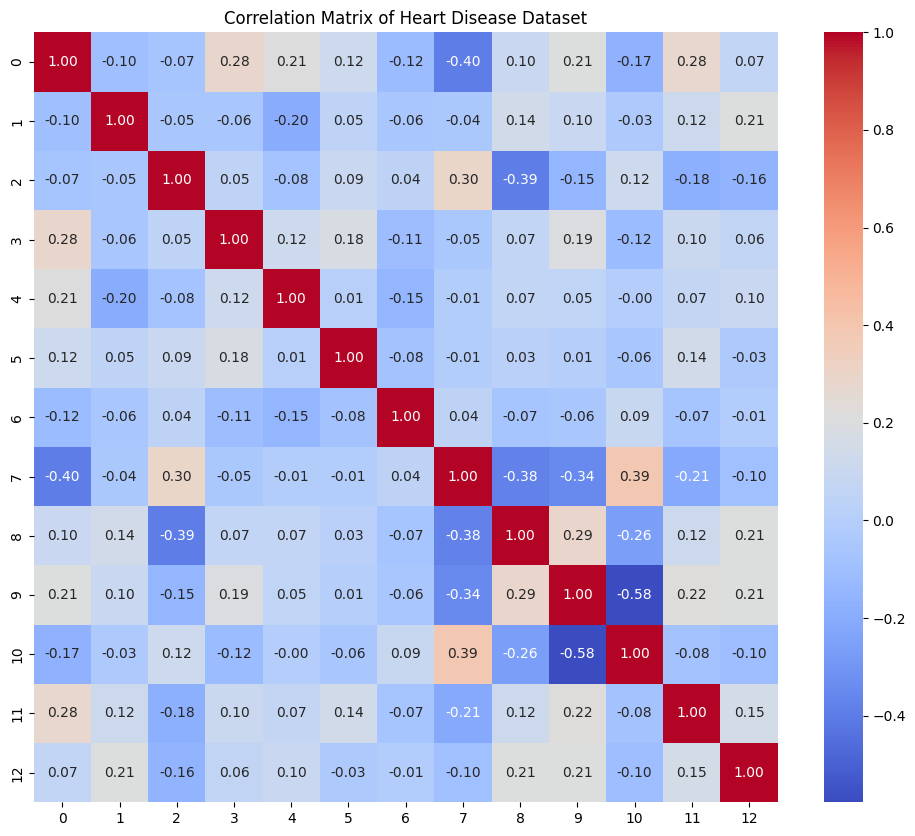

In [ ]:
correlation_df = correlation_matrix

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Heart Disease Dataset")
plt.show()

### Analisis Variabel Target

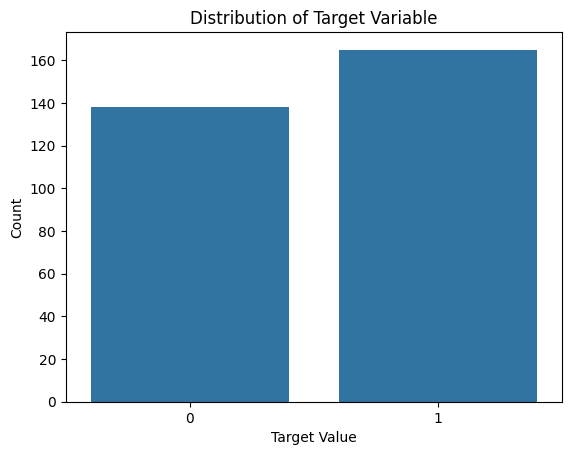

+------+-----+
|target|count|
+------+-----+
|     0|  138|
|     1|  165|
+------+-----+



In [ ]:
target_series = df.select("target").toPandas()["target"]

sns.countplot(x=target_series)
plt.xlabel("Target Value")
plt.ylabel("Count")
plt.title("Distribution of Target Variable")
plt.show()

target_temp = df.groupBy("target").count().orderBy("target")
target_temp.show()

In [ ]:
target_temp_values = target_temp.collect()

count_0 = target_temp_values[0]['count']
count_1 = target_temp_values[1]['count']

print("Percentage of patience without heart problems: "+str(round(count_0*100/303,2)))
print("Percentage of patience with heart problems: "+str(round(count_1*100/303,2)))

Percentage of patience without heart problems: 45.54
Percentage of patience with heart problems: 54.46


### Analisis Fitur Sex

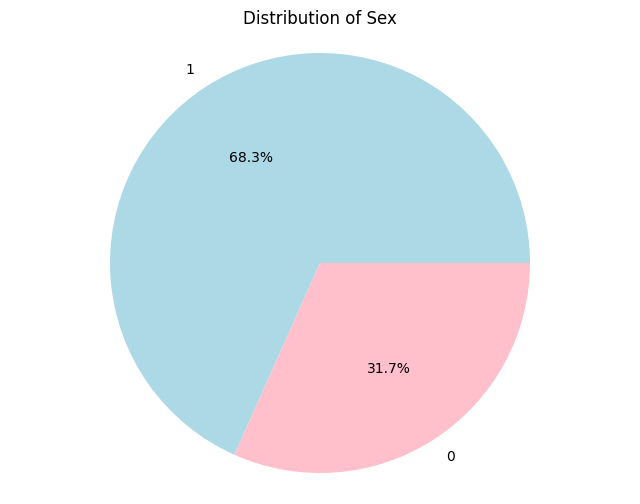

In [ ]:
sex_counts = df.groupBy("sex").count().toPandas()

plt.figure(figsize=(8, 6))
plt.pie(sex_counts['count'], labels=sex_counts['sex'], autopct='%1.1f%%', colors=['lightblue', 'pink'])
plt.title('Distribution of Sex')
plt.axis('equal')
plt.show()

## Analisis Fitur Age

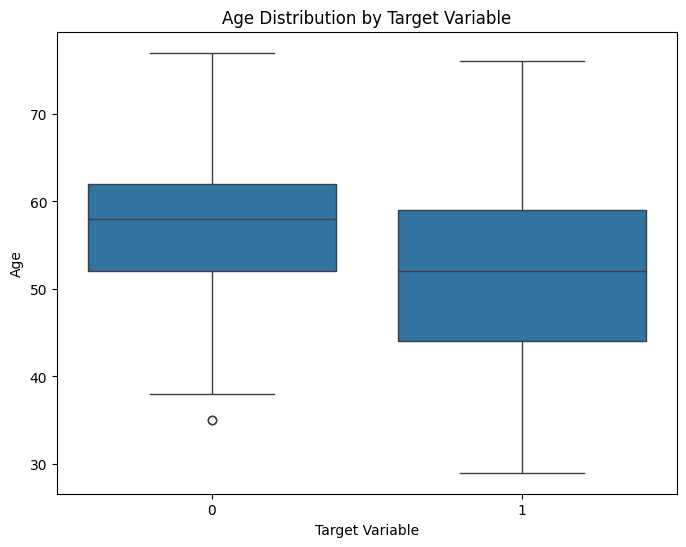

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="target", y="age", data=df.toPandas())
plt.xlabel("Target Variable")
plt.ylabel("Age")
plt.title("Age Distribution by Target Variable")
plt.show()

## Analisis Fitur Chol

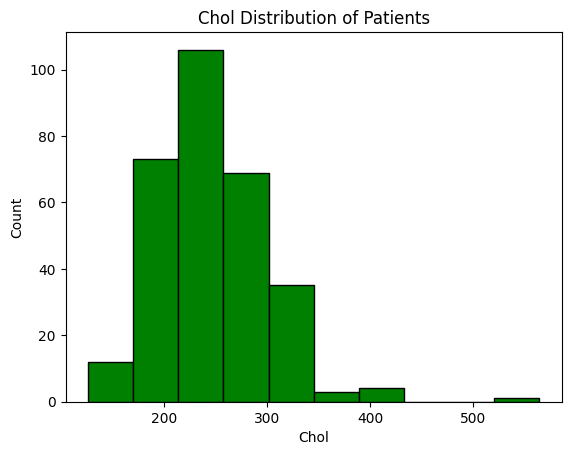

In [ ]:
chol_data = df.select("chol").toPandas()

plt.hist(chol_data["chol"], bins=10, color='green', edgecolor='black')
plt.title("Chol Distribution of Patients")
plt.xlabel("Chol")
plt.ylabel("Count")
plt.show()

## Train, Test, Split Data

In [ ]:
train_data, test_data = df_vector.randomSplit([0.8, 0.2], seed=0)

print(f"Jumlah data training: {train_data.count()}")
print(f"Jumlah data testing: {test_data.count()}")

Jumlah data training: 243
Jumlah data testing: 60


## MODEL MACHINE LEARNING

### **RANDOM FOREST**

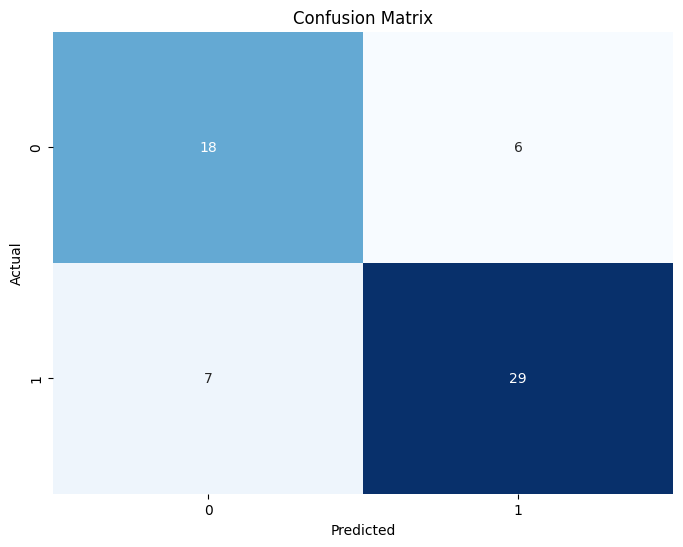

              precision    recall  f1-score   support

           0       0.72      0.75      0.73        24
           1       0.83      0.81      0.82        36

    accuracy                           0.78        60
   macro avg       0.77      0.78      0.78        60
weighted avg       0.79      0.78      0.78        60



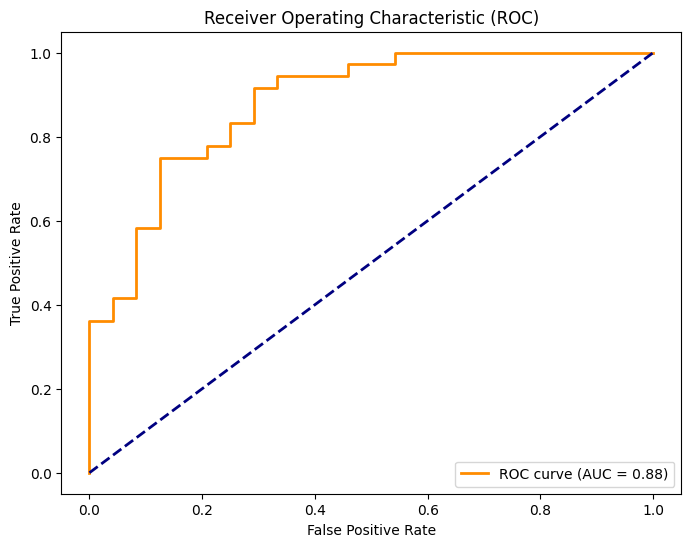

In [ ]:
# Train a RandomForestClassifier model
rf = RandomForestClassifier(labelCol="target", featuresCol="features", probabilityCol="probability")
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(rf_predictions)

# Convert to pandas DataFrame for classification report and confusion matrix
y_true = rf_predictions.select("target").toPandas()
y_pred = rf_predictions.select("prediction").toPandas()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred)
print(report)

# Calculate ROC and AUC
y_true_roc = rf_predictions.select("target").toPandas()
y_prob_roc = rf_predictions.select("probability").toPandas()

y_prob_roc = y_prob_roc['probability'].apply(lambda x: x[1])

fpr, tpr, thresholds = roc_curve(y_true_roc, y_prob_roc)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### **Gradient Boost Tree**

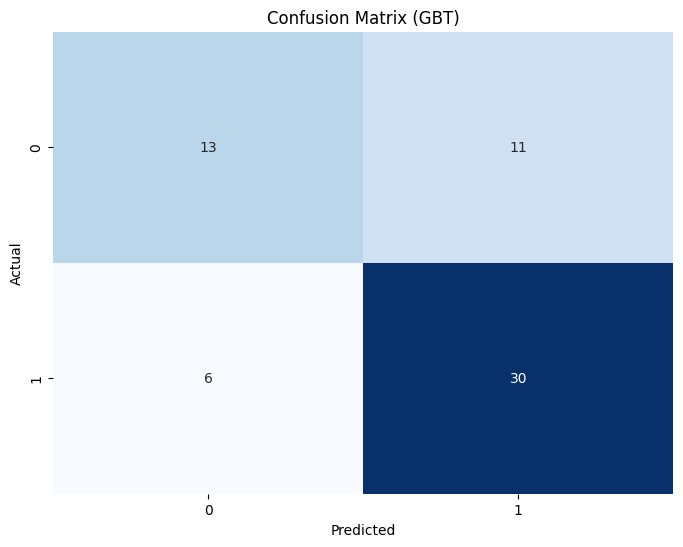

              precision    recall  f1-score   support

           0       0.68      0.54      0.60        24
           1       0.73      0.83      0.78        36

    accuracy                           0.72        60
   macro avg       0.71      0.69      0.69        60
weighted avg       0.71      0.72      0.71        60



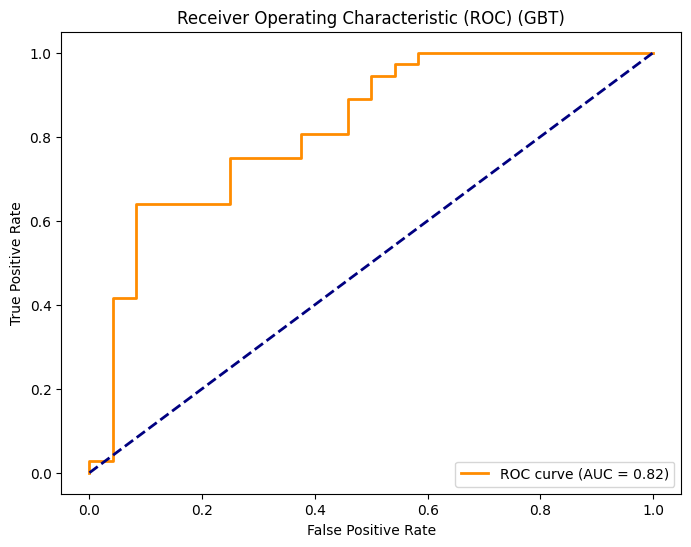

In [ ]:
# Train a GBTClassifier model
gbt = GBTClassifier(labelCol="target", featuresCol="features", maxIter=10)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(gbt_predictions)

# Convert to pandas DataFrame for classification report and confusion matrix
y_true = gbt_predictions.select("target").toPandas()
y_pred = gbt_predictions.select("prediction").toPandas()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (GBT)")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred)
print(report)

# Calculate ROC and AUC
y_true_roc = gbt_predictions.select("target").toPandas()
y_prob_roc = gbt_predictions.select("probability").toPandas()

# Assuming probability is a vector, extract the probability for class 1
y_prob_roc = y_prob_roc['probability'].apply(lambda x: x[1])

fpr, tpr, thresholds = roc_curve(y_true_roc, y_prob_roc)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) (GBT)')
plt.legend(loc="lower right")
plt.show()

### **XGBOOST**

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:54:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


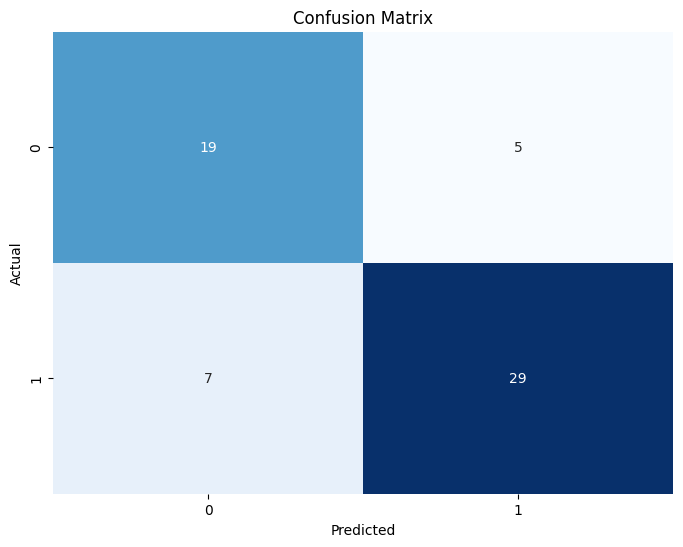

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        24
           1       0.85      0.81      0.83        36

    accuracy                           0.80        60
   macro avg       0.79      0.80      0.79        60
weighted avg       0.80      0.80      0.80        60



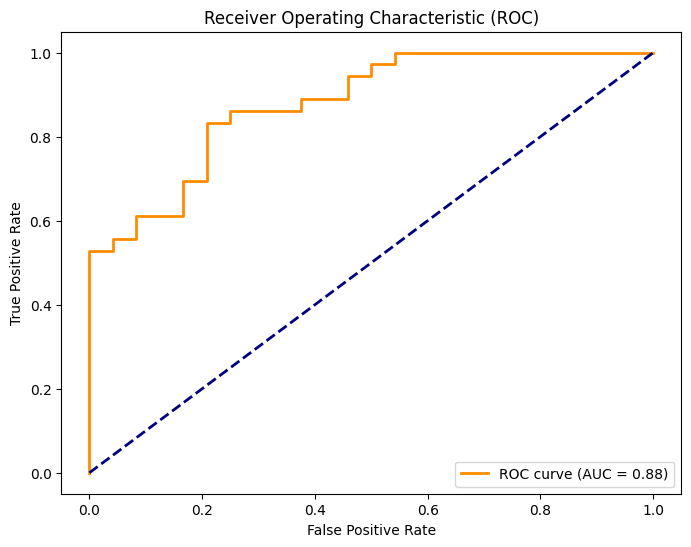

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Konversi data Spark ke Pandas
train_df = train_data.select("features", "target").toPandas()
test_df = test_data.select("features", "target").toPandas()

# Pisahkan fitur dan target
X_train = list(train_df['features'])
y_train = train_df['target']
X_test = list(test_df['features'])
y_test = test_df['target']

# Train an XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_estimators=100, learning_rate=0.1, max_depth=6)
xgb.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

# Evaluasi model
accuracy = xgb.score(X_test, y_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


### **Support Vector Machine (SVM)**

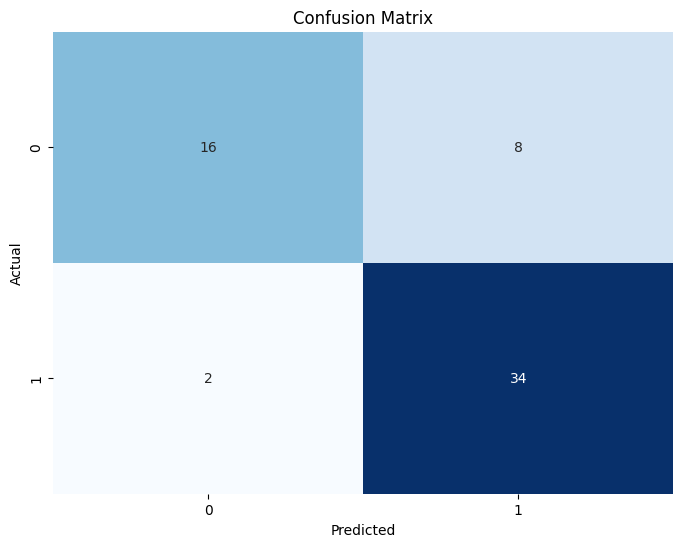

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        24
           1       0.81      0.94      0.87        36

    accuracy                           0.83        60
   macro avg       0.85      0.81      0.82        60
weighted avg       0.84      0.83      0.83        60



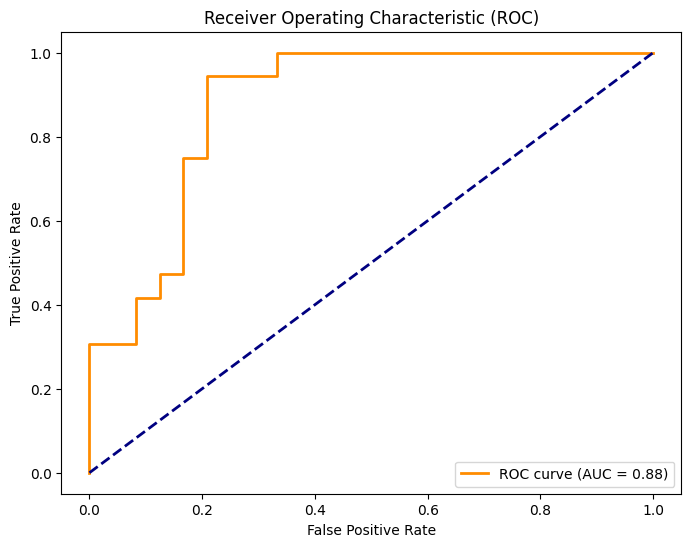

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Konversi data Spark ke Pandas
train_df = train_data.select("features", "target").toPandas()
test_df = test_data.select("features", "target").toPandas()

# Pisahkan fitur dan target
X_train = list(train_df['features'])
y_train = train_df['target']
X_test = list(test_df['features'])
y_test = test_df['target']

# Train an SVM model
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = svm.predict(X_test)
y_prob = svm.predict_proba(X_test)[:, 1]  # Probabilitas kelas positif

# Evaluasi model
accuracy = svm.score(X_test, y_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


### **Hyperparameter Tuning Random Forest**

In [ ]:
# Hyperparameter tuning for RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

paramGrid_rf = (ParamGridBuilder()
    .addGrid(rf.numTrees, [50, 100, 150])
    .addGrid(rf.maxDepth, [10, 20, 30])
    .build())

crossval_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=BinaryClassificationEvaluator(labelCol="target"),
    numFolds=5
)

# Fit model
cvModel_rf = crossval_rf.fit(train_data)
rf_predictions = cvModel_rf.transform(test_data)

# Evaluate Random Forest
evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="rawPrediction")
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Tuned Random Forest AUC: {rf_auc}")


Tuned Random Forest AUC: 0.900462962962963


### **Hyperparameter Tuning SVM**

In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Inisialisasi Model LinearSVC
svm = LinearSVC(labelCol="target", featuresCol="features")

# Membuat Parameter Grid untuk Hyperparameter Tuning
paramGrid_svm = (ParamGridBuilder()
                 .addGrid(svm.regParam, [0.1, 1, 10])  # C parameter is named regParam
                 .addGrid(svm.maxIter, [100, 200, 300])  # Add maxIter
                 .build())

# Membuat CrossValidator untuk Tuning (dengan seed untuk reproducibility)
crossval_svm = CrossValidator(
    estimator=svm,
    estimatorParamMaps=paramGrid_svm,
    evaluator=BinaryClassificationEvaluator(labelCol="target"),
    numFolds=5
)


# Melatih Model dengan Hyperparameter Tuning
cvModel_svm = crossval_svm.fit(train_data)
# Melakukan Prediksi dengan Model Terbaik
svm_predictions = cvModel_svm.transform(test_data)

# Evaluasi Model SVM setelah Tuning
evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="rawPrediction")
svm_auc = evaluator.evaluate(svm_predictions)
print(f"Tuned SVM AUC: {svm_auc}")

Tuned SVM AUC: 0.8969907407407407
